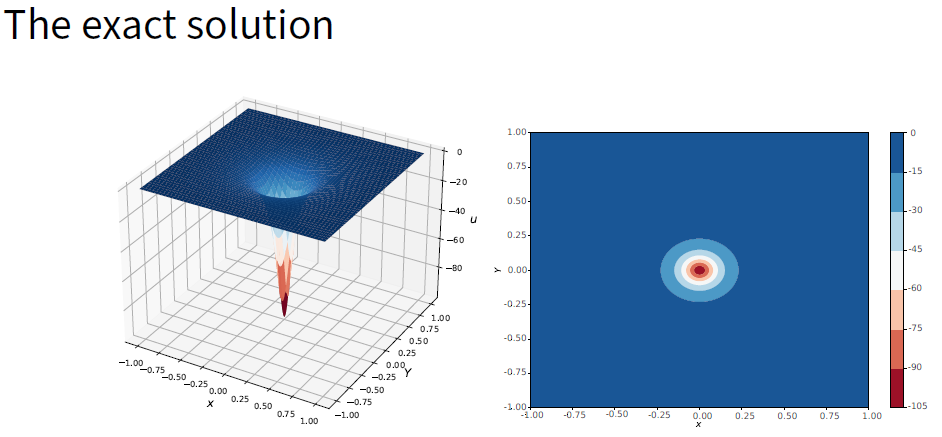

In [ ]:
# Import neded packages

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


# #%matplotlib widget
# %matplotlib inline


In [ ]:
# We move our tensor to the GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

In [3]:
# Defined the DGM network


#__________________________ The class that defines the DGM layer ______________________________

class DGM_layer(nn.Module):
    """
        The parametres:
                        d: dimension of the space domain
                        M: number of units in each layer
                  """

    def __init__(self,d,M):
        super(DGM_layer, self).__init__()
        self.Uz = nn.Linear(d, M, bias=False)
        self.Wzbz = nn.Linear(M, M)
        self.Ug = nn.Linear(d, M, bias=False)
        self.Wgbg = nn.Linear(M, M)
        self.Ur = nn.Linear(d, M, bias=False)
        self.Wrbr = nn.Linear(M, M)
        self.Uh = nn.Linear(d, M, bias=False)
        self.Whbh = nn.Linear(M, M)
        self.onesTens = torch.ones(M).to(device)

    def activation(self, x):
        return torch.tanh(x)
        #return torch.sigmoid(x)
        #return x * torch.sigmoid(x)
        #return torch.relu(x)
        #return torch.cos(x)

    def forward(self, xt, prevS):
        Z = self.activation(self.Uz(xt) + self.Wzbz(prevS))
        G = self.activation(self.Ug(xt) + self.Wgbg(prevS))
        R = self.activation(self.Ur(xt) + self.Wrbr(prevS))
        SR = prevS * R
        H = self.activation(self.Uh(xt) + self.Whbh(SR))
        return (self.onesTens - G) * H + Z * prevS


#__________________________ The class that defines the DGM network ______________________________


class DGM_Net(nn.Module):
    """
        The parametres:
                        d: dimension of the space domain
                        M: number of units in each layer
                        L: number of DGM layers
                        X: the vector of  spatial data
                        t: the vector of time data
                  """

    def __init__(self, d, M, L):
        super(DGM_Net, self).__init__()
        self.initial_layer = nn.Linear(d, M)
        self.middle_layers = nn.ModuleList([DGM_layer(d, M) for i in range(L)])
        self.final_layer = nn.Linear(M, 1)

    def activation(self, x):
        return torch.tanh(x)
        #return torch.sigmoid(x)
        #return x * torch.sigmoid(x)
        #return torch.relu(x)
        #return torch.cos(x)

    def forward(self, X):
        S = self.activation(self.initial_layer(X))
        for i, DGMlayer in enumerate(self.middle_layers):
            S = DGMlayer(X, S)
        return self.final_layer(S)


In [4]:
#_______________ hyperparameters __________________________________

dim = 2                          # imension of the space domain
M = 20                           # number of units in each layer
L = 3                            # number of DGM layers
num_eps = 50000                  # number of epochs totale
batch_size = 1024

mini_batch_size_bdry = 250
x_low = -1.0
x_high = 1.0               # domain dimensions

sigma = 0.05

alpha = 0.8
betha = 0.4

area = np.abs(x_high - x_low)**dim    # domain measure for using the Monte Carlo approximation

num_parts = 8                           # To choose a size of mini patch
mini_batch_size = batch_size // num_parts     # Calculate the size of mini patch


# used in calculating boundary loss
ones = torch.ones((mini_batch_size_bdry, 1))

In [5]:
#___________________ the analytical solution __________________________________________________________

def f(X):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    return ((4/(sigma**4)) * torch.exp(-(x**2 + y**2)/(sigma**2)) * (((x**2 + y**2)/(sigma**2))-1))

#___________________ the second member ________________________________________________________________

def U_exat(X):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    return -(1/(sigma**2))*torch.exp(-(x**2 + y**2)/(sigma**2))

In [6]:

   # the probability density function of the target distribution of probability
def target_proba(u, f, x, alpha):

    """
    The parametres:
                        u: the neural network
                        f: the second member of the PDE
                        X: the current point to evaluate
                                                            """
    x.requires_grad_()
    u_output = u(x)
    u_grad = torch.autograd.grad(u_output, x, grad_outputs=torch.ones_like(u_output), create_graph=True)[0]

    Δu = 0.0
    for i in range(dim):
        Δu += (torch.autograd.grad(u_grad[:,i], x, grad_outputs=torch.ones_like(u_grad[:,i]), create_graph=True)[0][:,i]).reshape(-1,1)

    P_x = (torch.abs( Δu + f(x)))**(alpha)
    P_sum = P_x.sum()
    return P_x/P_sum


In [7]:
#_______________ Mean errors ____________________________________

def absulat_ME(Uext,Upred):
    return  torch.sqrt(((Uext - Upred)**2).mean())

def relative_E(Uext,Upred):
    return torch.sqrt(((Uext - Upred)**2).mean()/((Uext)**2).mean())*100

In [8]:
def Ploting(xy_intr, xy_bdry, u_curent):
    grid_nums = 50
    x_grid = torch.linspace(x_low, x_high, grid_nums)
    XX, YY = torch.meshgrid(x_grid,x_grid)
    X = torch.reshape(XX, (-1,1))
    Y = torch.reshape(YY, (-1,1))
    XY = torch.cat((X,Y),1).to(device)
    with torch.no_grad():
        U = u_curent(XY)
    UU = torch.reshape(U, (grid_nums,grid_nums)).detach().cpu().numpy()
    U_ext =  U_exat(XY)
    U_ext = torch.reshape(U_ext , (grid_nums,grid_nums)).detach().cpu().numpy()

    # Create the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))

    # Plot the scatter plot
    ax1.scatter(xy_intr[:,0].detach().cpu().numpy(), xy_intr[:,1].detach().cpu().numpy(), s=2.5, label='Sampling points')
    ax1.scatter(xy_bdry, ones, s=2.5)
    ax1.scatter(xy_bdry, -ones, s=2.5)
    ax1.scatter(ones, xy_bdry, s=2.5)
    ax1.scatter(-ones, xy_bdry, s=2.5)
    #Plot the filled contour plot
    contour = ax2.contourf(XX.numpy(),YY.numpy(), UU - U_ext, levels=10, cmap='seismic')

    # Add a colorbar for the contour plot
    cbar = fig.colorbar(contour, ax=ax2)

    # Add legends and labels
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    # ax1.set_title('Sampling points')

    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    # ax2.set_title('Error between approximate and analytical solution')

    # Adjust spacing between subplots
    fig.tight_layout()

    # Show the figure
    plt.show()

In [9]:
# Define the learning rate schedule based on the number of epochs
def lr_lambda(epoch):
    if epoch <= 5000:
        return 1e-2
    elif 5000 < epoch <= 10000:
        return 5e-3
    elif 10000 < epoch <= 20000:
        return 1e-3
    elif 20000 < epoch <= 30000:
        return 5e-4
    elif 30000 < epoch <= 40000:
        return 1e-4
    elif 40000 < epoch <= 45000:
        return 5e-5
    else:
        return 1e-5

In [ ]:
#________________________ Training __________________________________________________________________________

u = DGM_Net(dim,M,L).to(device)   #  The network that will approach the solution


x_sampler = torch.distributions.uniform.Uniform(x_low, x_high)    #   to obtain the spatial data

# Create the optimizer and a LambdaLR scheduler with the defined learning rate schedule
optimizer = optim.Adam(u.parameters(),lr = 1)                   # Define the optimizer

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)  # to adjust learning rate


loss_train = np.zeros(num_eps)             # loss of taining inside the domaine
relative_E_losses = np.zeros(num_eps)              # losses initialization

print('\n Using {} device'.format(device))
for ep in range(num_eps):

    #______________Sampling point according the distribution P__________________
    u_sampling = u
    XY = x_sampler.sample((100*batch_size, dim)).to(device)

    P = target_proba(u, f, XY, alpha).detach().cpu().squeeze()
    m = torch.distributions.categorical.Categorical(P)
    XY_indices = m.sample([batch_size,1])
    x = XY[XY_indices].squeeze()

    #_____________Compute importance-sampling weight____________________________
    P_XY = P[XY_indices].squeeze()
    W_xy = (batch_size*P_XY)**(-betha)
    W_XY = torch.tensor(W_xy / W_xy.max()).to(device)


    #______________Divide the tensor into equal parts___________________________
    X_i = [x[i * mini_batch_size : (i + 1) * mini_batch_size] for i in range(num_parts)]
    W_XY_i = [W_XY[i * mini_batch_size : (i + 1) * mini_batch_size] for i in range(num_parts)]

    
    x_bndr = x_sampler.sample((mini_batch_size_bdry, 1))
    
    for w_XY_i, x_i in zip(W_XY_i,X_i):
        # evaluate forward pass, compute derivatives of network with respect to x
        x_i = torch.Tensor(x_i).to(device)
        x_i.requires_grad_()
        u_output = u(x_i)
        u_grad = torch.autograd.grad(u_output, x_i, grad_outputs=torch.ones_like(u_output), create_graph=True)[0]

        Δu = 0.0
        for i in range(dim):
            Δu += (torch.autograd.grad(u_grad[:,i], x_i, grad_outputs=torch.ones_like(u_grad[:,i]), create_graph=True)[0][:,i]).reshape(-1,1)

        L1 = area * torch.mean(w_XY_i * torch.pow((Δu + f(x_i)), 2))

        

        x_bry_1 = torch.cat((-ones,x_bndr),1).to(device)
        L2 = 2* torch.mean(torch.pow(u(x_bry_1), 2))
        x_bry_2 = torch.cat((ones,x_bndr),1).to(device)
        L3 = 2*torch.mean(torch.pow(u(x_bry_2), 2))
        y_bry_1 = torch.cat((x_bndr,-ones),1).to(device)
        L4 = 2*torch.mean(torch.pow(u(y_bry_1), 2))
        y_bry_2 = torch.cat((x_bndr,ones),1).to(device)
        L5 = 2*torch.mean(torch.pow(u(y_bry_2), 2))



        Loss = L1 + L2 + L3 + L4 + L5



        optimizer.zero_grad()
        Loss.backward(retain_graph=True)            # compute derivative of loss with respect to network parameters
        optimizer.step()           # update network parameters with ADAM

    # Update the learning rate
    scheduler.step(ep)  # Pass the current epoch to the scheduler

    # Display the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    relative_E_losses[ep] =  float(relative_E( U_exat(x) ,u(x)).item())
    loss_train[ep] = float(L1.item())
    if ep < 50:
        print("Epoch: %d - L_r:%f  loss_int : %.2f - REN : %.2f"%(ep, current_lr, loss_train[ep], relative_E_losses[ep]),"%")
        Ploting(x,x_bndr, u)
    elif ep % 1000 == 999:
        betha = betha + (1000/num_eps)
        print("Epoch: %d | L_r:%f | beta: %f | loss_int : %.2f | REN : %.2f"%(ep, current_lr,betha, loss_train[ep], relative_E_losses[ep]),"%")
        Ploting(x,x_bndr, u)



In [11]:

#_______________________________________________________________________________

grid_nums = 500
x_test = torch.distributions.uniform.Uniform(x_low, x_high).sample((grid_nums, dim)).to(device)
with torch.no_grad():
    U = u(x_test)

U_ext =  U_exat(x_test)

print("The Mean Absulat Error: {}".format(absulat_ME(U_ext,U)))
print("The Relative Error: {} %".format(relative_E(U_ext,U)))

The Mean Absulat Error: 0.23722721636295319
The Relative Error: 5.40956449508667 %


In [12]:
MSEabs = 0
MSErlf = 0
N = 100
for compt in range(N):
    x_test = torch.distributions.uniform.Uniform(x_low, x_high).sample((grid_nums, dim)).to(device)
    U = u(x_test)
    U_ext =  U_exat(x_test)

    MSEabs+= absulat_ME(U_ext,U)
    MSErlf+= relative_E(U_ext,U)

print("The averag of Mean Absulat Error: {}".format(MSEabs/N))
print("The averag of Relative Error: {} %".format(MSErlf/N))

The averag of Mean Absulat Error: 0.24233682453632355
The averag of Relative Error: 8.762937545776367 %


In [17]:
# #_______________________ Save Model _____________________________________

# torch.save(u.state_dict(), "Model_IS_DGM_Poisson_special_50000.pth") # to save weights
# np.save("loss_IS_DGM_Poisson_special_50000" ,Losse)                # to save Losse


In [18]:
# # #_______________________ load Model _____________________________________

# u_loaded = DGM_Net(dim,M,L).to(device)
# state_dict = torch.load("/content/Model_HM_determinist_DGM_Poisson_special_10000.pth")
# u_loaded.load_state_dict(state_dict)
# losse_standard = np.load("/content/loss_HM_determinist_DGM_Poisson_special_10000.pnry.npy")

In [19]:
#_______________ Ploting results __________________________________


# grid_nums = 50

# x_grid = torch.linspace(-1.0,1.0,grid_nums)
# XX, YY = torch.meshgrid(x_grid,x_grid)
# X = torch.reshape(XX, (-1,1))
# Y = torch.reshape(YY, (-1,1))
# XY = torch.cat((X,Y),1).to(device)
# with torch.no_grad():
#     U = u_loaded(XY)

# UU = torch.reshape(U, (grid_nums,grid_nums)).detach().cpu().numpy()
# U_ext =  U_exat(XY)
# U_ext = torch.reshape(U_ext , (grid_nums,grid_nums)).detach().cpu().numpy()

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.plot_surface(XX.numpy(),YY.numpy(), UU )


In [20]:
# Losse_HM  = losses.reshape(-1,1)
# Losse_standard  = losse_standard.reshape(-1,1)

# x_error = np.linspace(0,num_eps, num_eps)
# plt.plot(x_error, Losse_HM)
# plt.plot(x_error, Losse_standard)
# plt.show